In [ ]:

import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
import shap
import numpy as np
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
import shap
import numpy as np
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class InLegalBERTClassifier(nn.Module):
    def __init__(self, n_classes):
        super(InLegalBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("law-ai/InLegalBERT")
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None, token_type_ids=None): # Accept token_type_ids
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask, inputs_embeds=inputs_embeds)
        return self.out(self.drop(output.pooler_output))

tokenizer = AutoTokenizer.from_pretrained("law-ai/InLegalBERT")
model = InLegalBERTClassifier(n_classes=2)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/best_model_state (1).bin", map_location=device))
model.eval().to(device)

InLegalBERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [ ]:

def predict_fn(texts):
    if isinstance(texts, np.ndarray): texts = texts.tolist()
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs)
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()


In [ ]:

def shap_with_fgsm(text, epsilon):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)

    # Clean SHAP
    explainer_clean = shap.Explainer(predict_fn, shap.maskers.Text(tokenizer))
    shap_values_clean = explainer_clean([text])

    # FGSM
    embedding_layer = model.bert.embeddings.word_embeddings
    inputs_embeds = embedding_layer(input_ids).detach().clone().requires_grad_(True)
    logits = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
    predicted_label = logits.argmax(dim=-1).detach()
    loss = torch.nn.functional.cross_entropy(logits, predicted_label)
    model.zero_grad()
    loss.backward()
    grad = inputs_embeds.grad
    adv_embeds = inputs_embeds + epsilon * grad.sign()

    # Decode adversarial tokens
    with torch.no_grad():
        token_embeddings = embedding_layer.weight.to(device)
        sim = torch.nn.functional.cosine_similarity(adv_embeds.view(-1, adv_embeds.size(-1)).unsqueeze(1),
                                                     token_embeddings.unsqueeze(0), dim=2)
        adv_token_ids = sim.argmax(dim=-1).view(input_ids.shape)
        adv_text = tokenizer.decode(adv_token_ids[0], skip_special_tokens=True)

    # Adversarial SHAP
    explainer_adv = shap.Explainer(predict_fn, shap.maskers.Text(tokenizer))
    shap_values_adv = explainer_adv([adv_text])

    return shap_values_clean[0], shap_values_adv[0], text, adv_text


In [ ]:
with open ("/content/drive/MyDrive/Colab Notebooks/JusttextforFGSM.txt") as f:
  text = f.readlines()



In [ ]:

def compare_shap(shap_clean, shap_adv):
    def extract_top(shap_vals):
        vals = shap_vals.values
        tokens = shap_vals.data
        class_idx = np.argmax(predict_fn([" ".join(tokens)]))
        scores = [abs(v[class_idx]) for v in vals]
        df = pd.DataFrame(list(zip(tokens, scores)), columns=["Token", "Importance"])
        df = df[df["Token"].str.isalpha()].drop_duplicates("Token").nlargest(20, "Importance")
        return df.reset_index(drop=True)

    df_clean = extract_top(shap_clean)
    df_adv = extract_top(shap_adv)
    print("Original Top Words:", df_clean)
    print("Adversarial Top Words:", df_adv)
    return df_clean, df_adv


In [ ]:
def run(text, epsilon):
    shap_clean, shap_adv, clean_text, adv_text = shap_with_fgsm(text,epsilon)

    print("\nClean Input Text:\n", clean_text)
    print("\nAdversarial Input Text:\n", adv_text)

    # Get and print predictions
    clean_pred = predict_fn([clean_text])
    adv_pred = predict_fn([adv_text])

    print("\nClean Text Prediction (Probabilities):", clean_pred)
    print("Adversarial Text Prediction (Probabilities):", adv_pred)


    #compare_shap(shap_clean, shap_adv)
    return clean_text, adv_text, clean_pred, adv_pred

In [ ]:
l2 = []
for j in range(10, 15, 1):
  text1 = text[j][0:600]
  l1 = []
  for i in range(100, 150, 5):
    a,b,c,d = run(text1, i/1000)
    l1.append([a,b,c,d,i/1000])
  l2.append(l1)


  0%|          | 0/498 [00:00<?, ?it/s]




PartitionExplainer explainer: 2it [01:07, 67.07s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:06, 66.00s/it]               



Clean Input Text:
  M. KHANWILKAR, J. The principal question involved in these appeals is whether the subject sales  of goods imported from foreign companyntry and after Signature Not Verified Digitally signed by unloading the same on the landmass of the State of West Bengal, DEEPAK SINGH Date 2020.01.21 174050 IST Reason kept in the bonded warehouse without payment of customs duty  to foreign bound ships as ship stores can be regarded as sale within the territory of the State and amenable to sales tax under the West Bengal Sales Tax Act, 1954  for short, the 1954 Act  or the West Bengal Sales Tax Act, 1994  for

Adversarial Input Text:
 m. khanwilkar newline j. the principal question involved in these appeals is whether the subject sales of goods imported from foreign companyntry and after signature not verified digitally signed by unloading the same on the landmass of the state of west bengal, deepak singh date 2020. 01. 21 174050 ist reason kept in the bonded warehouse without paym

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:07, 67.28s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:16, 76.44s/it]               



Clean Input Text:
  M. KHANWILKAR, J. The principal question involved in these appeals is whether the subject sales  of goods imported from foreign companyntry and after Signature Not Verified Digitally signed by unloading the same on the landmass of the State of West Bengal, DEEPAK SINGH Date 2020.01.21 174050 IST Reason kept in the bonded warehouse without payment of customs duty  to foreign bound ships as ship stores can be regarded as sale within the territory of the State and amenable to sales tax under the West Bengal Sales Tax Act, 1954  for short, the 1954 Act  or the West Bengal Sales Tax Act, 1994  for

Adversarial Input Text:
 m. khanwilkar newline j. the principal question involved in these appeals is whether the subject sales of goods imported from foreign companyntry and after signature not verified digitally signed by unloading the same on the landmass of the state of west bengal, deepak singh date 2020. 01. 21 174050 ist reason kept in the bonded warehouse without paym

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:08, 68.30s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:07, 67.52s/it]               



Clean Input Text:
  M. KHANWILKAR, J. The principal question involved in these appeals is whether the subject sales  of goods imported from foreign companyntry and after Signature Not Verified Digitally signed by unloading the same on the landmass of the State of West Bengal, DEEPAK SINGH Date 2020.01.21 174050 IST Reason kept in the bonded warehouse without payment of customs duty  to foreign bound ships as ship stores can be regarded as sale within the territory of the State and amenable to sales tax under the West Bengal Sales Tax Act, 1954  for short, the 1954 Act  or the West Bengal Sales Tax Act, 1994  for

Adversarial Input Text:
 m. khanwilkar newline j. the principal question involved in these appeals is whether the subject sales of goods imported from foreign companyntry and after signature not verified digitally signed by unloading the same on the landmass of the state of west bengal, deepak singh date 2020. 01. 21 174050 ist reason kept in the bonded warehouse without paym

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.36s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.80s/it]               



Clean Input Text:
  M. KHANWILKAR, J. The principal question involved in these appeals is whether the subject sales  of goods imported from foreign companyntry and after Signature Not Verified Digitally signed by unloading the same on the landmass of the State of West Bengal, DEEPAK SINGH Date 2020.01.21 174050 IST Reason kept in the bonded warehouse without payment of customs duty  to foreign bound ships as ship stores can be regarded as sale within the territory of the State and amenable to sales tax under the West Bengal Sales Tax Act, 1954  for short, the 1954 Act  or the West Bengal Sales Tax Act, 1994  for

Adversarial Input Text:
 m. khanwilkar newline j. the principal question involved in these appeals is whether the subject sales of goods imported from foreign companyntry and after signature not verified digitally signed by unloading the same on the landmass of the state of west bengal, deepak singh date 2020. 01. 21 174050 ist reason kept in the bonded warehouse without paym

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:06, 66.72s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:12, 72.05s/it]               



Clean Input Text:
  M. KHANWILKAR, J. The principal question involved in these appeals is whether the subject sales  of goods imported from foreign companyntry and after Signature Not Verified Digitally signed by unloading the same on the landmass of the State of West Bengal, DEEPAK SINGH Date 2020.01.21 174050 IST Reason kept in the bonded warehouse without payment of customs duty  to foreign bound ships as ship stores can be regarded as sale within the territory of the State and amenable to sales tax under the West Bengal Sales Tax Act, 1954  for short, the 1954 Act  or the West Bengal Sales Tax Act, 1994  for

Adversarial Input Text:
 m. khanwilkar newline j. the principal question involved in these appeals is whether the subject sales of goods imported from foreign companyntry and after signature not verified digitally signed by unloading the same on the landmass of the state of west bengal, deepak singh date 2020. 01. 21 174050 ist reason kept in the bonded warehouse without paym

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:13, 73.88s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:18, 78.07s/it]               



Clean Input Text:
  M. KHANWILKAR, J. The principal question involved in these appeals is whether the subject sales  of goods imported from foreign companyntry and after Signature Not Verified Digitally signed by unloading the same on the landmass of the State of West Bengal, DEEPAK SINGH Date 2020.01.21 174050 IST Reason kept in the bonded warehouse without payment of customs duty  to foreign bound ships as ship stores can be regarded as sale within the territory of the State and amenable to sales tax under the West Bengal Sales Tax Act, 1954  for short, the 1954 Act  or the West Bengal Sales Tax Act, 1994  for

Adversarial Input Text:
 m. khanwilkar newline j. the principal question involved in these appeals is whether the subject sales of goods imported from foreign companyntry and after signature not verified digitally signed by unloading the same on the landmass of the state of west bengal, deepak singh date 2020. 01. 21 174050 ist reason kept in the bonded warehouse without paym

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:16, 76.70s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:37, 97.50s/it]               



Clean Input Text:
  M. KHANWILKAR, J. The principal question involved in these appeals is whether the subject sales  of goods imported from foreign companyntry and after Signature Not Verified Digitally signed by unloading the same on the landmass of the State of West Bengal, DEEPAK SINGH Date 2020.01.21 174050 IST Reason kept in the bonded warehouse without payment of customs duty  to foreign bound ships as ship stores can be regarded as sale within the territory of the State and amenable to sales tax under the West Bengal Sales Tax Act, 1954  for short, the 1954 Act  or the West Bengal Sales Tax Act, 1994  for

Adversarial Input Text:
 m. khanwilkar j. the principal question involved in these appeals is whether the subject sales of goods imported from foreign companyntry and after signature not verified digitally signed by unloading the same on the landmass of the state of west bengal, deepak singh date 2020. 01. 21 174050 ist reason kept in the bonded warehouse without payment of c

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:11, 71.02s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:09, 69.93s/it]               



Clean Input Text:
  M. KHANWILKAR, J. The principal question involved in these appeals is whether the subject sales  of goods imported from foreign companyntry and after Signature Not Verified Digitally signed by unloading the same on the landmass of the State of West Bengal, DEEPAK SINGH Date 2020.01.21 174050 IST Reason kept in the bonded warehouse without payment of customs duty  to foreign bound ships as ship stores can be regarded as sale within the territory of the State and amenable to sales tax under the West Bengal Sales Tax Act, 1954  for short, the 1954 Act  or the West Bengal Sales Tax Act, 1994  for

Adversarial Input Text:
 m. khanwilkar j. the principal question involved in these appeals is whether the subject sales of goods imported from foreign companyntry and after signature not verified digitally signed by unloading the same on the landmass of the state of west bengal, deepak singh date 2020. 01. 21 174050 ist reason kept in the bonded warehouse without payment of c

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:08, 68.21s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:07, 67.91s/it]               



Clean Input Text:
  M. KHANWILKAR, J. The principal question involved in these appeals is whether the subject sales  of goods imported from foreign companyntry and after Signature Not Verified Digitally signed by unloading the same on the landmass of the State of West Bengal, DEEPAK SINGH Date 2020.01.21 174050 IST Reason kept in the bonded warehouse without payment of customs duty  to foreign bound ships as ship stores can be regarded as sale within the territory of the State and amenable to sales tax under the West Bengal Sales Tax Act, 1954  for short, the 1954 Act  or the West Bengal Sales Tax Act, 1994  for

Adversarial Input Text:
 m. khanwilkar j. the principal question involved in these appeals is whether the subject sales of goods imported from foreign companyntry and after signature not verified digitally signed by unloading the same on the landmass of the state of west bengal, deepak singh date 2020. 01. 21 174050 ist reason kept in the bonded warehouse without payment of c

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:09, 69.41s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:23, 83.90s/it]               



Clean Input Text:
  M. KHANWILKAR, J. The principal question involved in these appeals is whether the subject sales  of goods imported from foreign companyntry and after Signature Not Verified Digitally signed by unloading the same on the landmass of the State of West Bengal, DEEPAK SINGH Date 2020.01.21 174050 IST Reason kept in the bonded warehouse without payment of customs duty  to foreign bound ships as ship stores can be regarded as sale within the territory of the State and amenable to sales tax under the West Bengal Sales Tax Act, 1954  for short, the 1954 Act  or the West Bengal Sales Tax Act, 1994  for

Adversarial Input Text:
 m. khanwilkar j. the principal question involved in these appeals is whether the subject sales of goods imported from foreign companyntry and after signature not verified digitally signed by unloading the same on the landmass of the state of west bengal, deepak singh date 2020. 01. 21 174050 ist reason kept in the bonded warehouse without and of custo

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.99s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:02, 62.37s/it]               



Clean Input Text:
  F. Nariman, J. Leave granted. The Appeals in the present case raise important questions relating to the Tenth Schedule to the Constitution of India Signature Not Verified  hereinafter referred to as Tenth Schedule . The election for the Digitally signed by R NATARAJAN Date 2020.01.21 170655 IST Reason 11th Manipur Legislative Assembly was companyducted in March, 2017. The said Assembly election produced an inconclusive result as numbere of the political parties were able to secure a majority i.e. 31 seats in a Legislative Assembly of 60 seats in order to form the Government. The Indian Nation

Adversarial Input Text:
 f. nariman, j. leave granted. the appeals in the present case raise important questions relating to the tenth schedule to the constitution of india signature not verified hereinafter referred to as tenth schedule. the election for the digitally signed by r natarajan date 2020. 01. 21 170655 ist reason 11th manipur legislative assembly was companyducte

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.38s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:04, 64.00s/it]               



Clean Input Text:
  F. Nariman, J. Leave granted. The Appeals in the present case raise important questions relating to the Tenth Schedule to the Constitution of India Signature Not Verified  hereinafter referred to as Tenth Schedule . The election for the Digitally signed by R NATARAJAN Date 2020.01.21 170655 IST Reason 11th Manipur Legislative Assembly was companyducted in March, 2017. The said Assembly election produced an inconclusive result as numbere of the political parties were able to secure a majority i.e. 31 seats in a Legislative Assembly of 60 seats in order to form the Government. The Indian Nation

Adversarial Input Text:
 f. nariman, j. leave granted. the appeals in the present case raise important questions relating to to tenth schedule to the constitution of india signature not verified hereinafter referred to as tenth schedule. the election for the digitally signed by r natarajan date 2020. 01. 21 170655 ist reason 11th manipur legislative assembly was companyducted

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.13s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.41s/it]               



Clean Input Text:
  F. Nariman, J. Leave granted. The Appeals in the present case raise important questions relating to the Tenth Schedule to the Constitution of India Signature Not Verified  hereinafter referred to as Tenth Schedule . The election for the Digitally signed by R NATARAJAN Date 2020.01.21 170655 IST Reason 11th Manipur Legislative Assembly was companyducted in March, 2017. The said Assembly election produced an inconclusive result as numbere of the political parties were able to secure a majority i.e. 31 seats in a Legislative Assembly of 60 seats in order to form the Government. The Indian Nation

Adversarial Input Text:
 f. nariman, j. leave granted. the appeals in the present case raised important questions relating to to tenth schedule to the constitution of india signature not verified hereinafter referred to as tenth schedule. the election for the digitally signed by r natarajan date 2020. 01. 21 170655 ist reason 11th manipur legislative assembly was companyducte

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:04, 64.53s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:04, 64.78s/it]               



Clean Input Text:
  F. Nariman, J. Leave granted. The Appeals in the present case raise important questions relating to the Tenth Schedule to the Constitution of India Signature Not Verified  hereinafter referred to as Tenth Schedule . The election for the Digitally signed by R NATARAJAN Date 2020.01.21 170655 IST Reason 11th Manipur Legislative Assembly was companyducted in March, 2017. The said Assembly election produced an inconclusive result as numbere of the political parties were able to secure a majority i.e. 31 seats in a Legislative Assembly of 60 seats in order to form the Government. The Indian Nation

Adversarial Input Text:
 f. nariman, j. leave granted. the appeals in the present case raised important questions relating to to tenth schedule to the constitution of india signature not verified hereinafter referred to as tenth schedule. the election for the digitally signed by r natarajan date 2020. 01. 21 170655 ist reason 11th manipur legislative assembly was companyducte

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:14, 74.39s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:08, 68.14s/it]               



Clean Input Text:
  F. Nariman, J. Leave granted. The Appeals in the present case raise important questions relating to the Tenth Schedule to the Constitution of India Signature Not Verified  hereinafter referred to as Tenth Schedule . The election for the Digitally signed by R NATARAJAN Date 2020.01.21 170655 IST Reason 11th Manipur Legislative Assembly was companyducted in March, 2017. The said Assembly election produced an inconclusive result as numbere of the political parties were able to secure a majority i.e. 31 seats in a Legislative Assembly of 60 seats in order to form the Government. The Indian Nation

Adversarial Input Text:
 f. nariman, j. leave granted. the appeals in the present case raised important questions relating to to tenth schedule to the constitution of india signature not verified hereinafter referred to as tenth schedule. the election for the digitally signed by r natarajan date 2020. 01. 21 170655 ist reason 11th manipur legislative assembly was companyducte

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.30s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.67s/it]               



Clean Input Text:
  F. Nariman, J. Leave granted. The Appeals in the present case raise important questions relating to the Tenth Schedule to the Constitution of India Signature Not Verified  hereinafter referred to as Tenth Schedule . The election for the Digitally signed by R NATARAJAN Date 2020.01.21 170655 IST Reason 11th Manipur Legislative Assembly was companyducted in March, 2017. The said Assembly election produced an inconclusive result as numbere of the political parties were able to secure a majority i.e. 31 seats in a Legislative Assembly of 60 seats in order to form the Government. The Indian Nation

Adversarial Input Text:
 f. nariman, j newline leave granted. the appeals in the present case raised important questions relating to to tenth schedule to the constitution of india signature not verified hereinafter referred to as tenth schedule. the election for the digitally signed by r natarajan date 2020. 01. 21 170655 ist reason 11th manipur legislative assembly was compa

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:04, 64.35s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:02, 62.55s/it]               



Clean Input Text:
  F. Nariman, J. Leave granted. The Appeals in the present case raise important questions relating to the Tenth Schedule to the Constitution of India Signature Not Verified  hereinafter referred to as Tenth Schedule . The election for the Digitally signed by R NATARAJAN Date 2020.01.21 170655 IST Reason 11th Manipur Legislative Assembly was companyducted in March, 2017. The said Assembly election produced an inconclusive result as numbere of the political parties were able to secure a majority i.e. 31 seats in a Legislative Assembly of 60 seats in order to form the Government. The Indian Nation

Adversarial Input Text:
 f. nariman, j newline leave granted. the appeals in the present case raised important questions relating to to tenth schedule to the constitution of india signature not verified hereinafter referred to as tenth schedule. the election for the digitally signed by r natarajan date 2020. 01. 21 170655 ist reason 11th manipur legislative assembly was compa

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.38s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.79s/it]               



Clean Input Text:
  F. Nariman, J. Leave granted. The Appeals in the present case raise important questions relating to the Tenth Schedule to the Constitution of India Signature Not Verified  hereinafter referred to as Tenth Schedule . The election for the Digitally signed by R NATARAJAN Date 2020.01.21 170655 IST Reason 11th Manipur Legislative Assembly was companyducted in March, 2017. The said Assembly election produced an inconclusive result as numbere of the political parties were able to secure a majority i.e. 31 seats in a Legislative Assembly of 60 seats in order to form the Government. The Indian Nation

Adversarial Input Text:
 f. nariman, j newline leave granted. the appeals in the present case raised important questions relating to to tenth schedule to the constitution of india signature not verified hereinafter referred to as tenth schedule. the election for the digitally signed by r natarajan date 2020. 01. 21 170655 ist reason 11th manipur legislative assembly was compa

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:02, 62.04s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:05, 65.72s/it]               



Clean Input Text:
  F. Nariman, J. Leave granted. The Appeals in the present case raise important questions relating to the Tenth Schedule to the Constitution of India Signature Not Verified  hereinafter referred to as Tenth Schedule . The election for the Digitally signed by R NATARAJAN Date 2020.01.21 170655 IST Reason 11th Manipur Legislative Assembly was companyducted in March, 2017. The said Assembly election produced an inconclusive result as numbere of the political parties were able to secure a majority i.e. 31 seats in a Legislative Assembly of 60 seats in order to form the Government. The Indian Nation

Adversarial Input Text:
 f. nariman, j newline leave granted. the appeals in the present case raised important questions relating to to tenth schedule to the constitution of india signature not verified hereinafter referred to as tenth schedule. the election for the digitally signed by r natarajan date 2020. 01. 21 170655 ist reason 11th manipur legislative assembly was compa

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:16, 76.11s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:00, 60.88s/it]               



Clean Input Text:
  F. Nariman, J. Leave granted. The Appeals in the present case raise important questions relating to the Tenth Schedule to the Constitution of India Signature Not Verified  hereinafter referred to as Tenth Schedule . The election for the Digitally signed by R NATARAJAN Date 2020.01.21 170655 IST Reason 11th Manipur Legislative Assembly was companyducted in March, 2017. The said Assembly election produced an inconclusive result as numbere of the political parties were able to secure a majority i.e. 31 seats in a Legislative Assembly of 60 seats in order to form the Government. The Indian Nation

Adversarial Input Text:
 f. nariman, j newline leave granted. the appeals in the present case raised important questions relating to to tenth schedule to the constitution of india signature not verified hereinafter referred to as tenth schedule. the election for the digitally signed by r natarajan date 2020. 01. 21 170655 ist reason 11th manipur legislative assembly was compa

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.14s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:05, 65.39s/it]               



Clean Input Text:
  Dr Dhananjaya Y Chandrachud, J 1 This appeal arises from the judgment of a Single Judge of the High Court of Andhra Pradesh dated 6 March 2019. A revision petition 1 filed by the fourth respondent against an order of the Additional Junior Civil Judge, Sattenapalli was allowed and directions were issued for the framing of charges against the appellant under Sections 406 and 420 of the Indian Penal Code 1860 2. 2 On 10 March 2011, a First Information Report 3 was lodged by the fourth respondent, who is the father-in-law of the appellant, alleging that the appellant Signature Not Verified Digita

Adversarial Input Text:
 dr dhananjaya y chandrachud, j 1 this appeal arises from the judgment of a single judge of the high court of andhra pradesh dated 6 march 2019. a revision petition 1 filed by the fourth respondent against an order of the additional junior civil judge, sattenapalli was allowed and directions were issued for in framing of charges against the appellant u

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:07, 67.12s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:04, 64.16s/it]               



Clean Input Text:
  Dr Dhananjaya Y Chandrachud, J 1 This appeal arises from the judgment of a Single Judge of the High Court of Andhra Pradesh dated 6 March 2019. A revision petition 1 filed by the fourth respondent against an order of the Additional Junior Civil Judge, Sattenapalli was allowed and directions were issued for the framing of charges against the appellant under Sections 406 and 420 of the Indian Penal Code 1860 2. 2 On 10 March 2011, a First Information Report 3 was lodged by the fourth respondent, who is the father-in-law of the appellant, alleging that the appellant Signature Not Verified Digita

Adversarial Input Text:
 dr dhananjaya y chandrachud, j 1 this appeal arises from the judgment of a single judge of the high court of andhra pradesh dated 6 march 2019. a revision petition 1 filed by the fourth respondent against an order of the additional junior civil judge, sattenapalli was allowed and directions were issued for in framing of charges against the appellant u

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:25, 85.69s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:06, 66.68s/it]               



Clean Input Text:
  Dr Dhananjaya Y Chandrachud, J 1 This appeal arises from the judgment of a Single Judge of the High Court of Andhra Pradesh dated 6 March 2019. A revision petition 1 filed by the fourth respondent against an order of the Additional Junior Civil Judge, Sattenapalli was allowed and directions were issued for the framing of charges against the appellant under Sections 406 and 420 of the Indian Penal Code 1860 2. 2 On 10 March 2011, a First Information Report 3 was lodged by the fourth respondent, who is the father-in-law of the appellant, alleging that the appellant Signature Not Verified Digita

Adversarial Input Text:
 dr dhananjaya y chandrachud, j 1 this appeal arises from the judgment of a single judge of the high court of andhra pradesh dated 6 march 2019. a revision petition 1 filed by the fourth respondent against an order of the additional junior civil judge, sattenapalli was allowed and directions were issued for in framing of charges against the appellant u

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:17, 77.42s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:08, 68.79s/it]               



Clean Input Text:
  Dr Dhananjaya Y Chandrachud, J 1 This appeal arises from the judgment of a Single Judge of the High Court of Andhra Pradesh dated 6 March 2019. A revision petition 1 filed by the fourth respondent against an order of the Additional Junior Civil Judge, Sattenapalli was allowed and directions were issued for the framing of charges against the appellant under Sections 406 and 420 of the Indian Penal Code 1860 2. 2 On 10 March 2011, a First Information Report 3 was lodged by the fourth respondent, who is the father-in-law of the appellant, alleging that the appellant Signature Not Verified Digita

Adversarial Input Text:
 dr dhananjaya y chandrachud, j 1 this appeal arises from the judgment of a single judge of the high court of andhra pradesh dated 6 march 2019. a revision petition 1 filed by the fourth respondent against an order of the additional junior civil judge, sattenapalli was allowed and directions were issued for in framing of charges against the appellant u

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:09, 69.17s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:05, 65.75s/it]               



Clean Input Text:
  Dr Dhananjaya Y Chandrachud, J 1 This appeal arises from the judgment of a Single Judge of the High Court of Andhra Pradesh dated 6 March 2019. A revision petition 1 filed by the fourth respondent against an order of the Additional Junior Civil Judge, Sattenapalli was allowed and directions were issued for the framing of charges against the appellant under Sections 406 and 420 of the Indian Penal Code 1860 2. 2 On 10 March 2011, a First Information Report 3 was lodged by the fourth respondent, who is the father-in-law of the appellant, alleging that the appellant Signature Not Verified Digita

Adversarial Input Text:
 dr dhananjaya y chandrachud, j 1 this appeal arises from the judgment of a single judge of the high court of andhra pradesh dated 6 march 2019. a revision petition 1 filed by the fourth respondent against an order of the additional junior civil judge, sattenapalli was allowed and directions were issued for ) framing of charges against as appellant und

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:06, 66.26s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:05, 65.03s/it]               



Clean Input Text:
  Dr Dhananjaya Y Chandrachud, J 1 This appeal arises from the judgment of a Single Judge of the High Court of Andhra Pradesh dated 6 March 2019. A revision petition 1 filed by the fourth respondent against an order of the Additional Junior Civil Judge, Sattenapalli was allowed and directions were issued for the framing of charges against the appellant under Sections 406 and 420 of the Indian Penal Code 1860 2. 2 On 10 March 2011, a First Information Report 3 was lodged by the fourth respondent, who is the father-in-law of the appellant, alleging that the appellant Signature Not Verified Digita

Adversarial Input Text:
 dr dhananjaya y chandrachud, j 1 this appeal arises from the judgment of a single judge of the high court of andhra pradesh dated 6 march 2019. a revision petition 1 filed by the fourth respondent against an order of the additional junior civil judge, sattenapalli was allowed and directions were issued for ) framing of charges against as appellant und

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:06, 66.13s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:10, 70.34s/it]               



Clean Input Text:
  Dr Dhananjaya Y Chandrachud, J 1 This appeal arises from the judgment of a Single Judge of the High Court of Andhra Pradesh dated 6 March 2019. A revision petition 1 filed by the fourth respondent against an order of the Additional Junior Civil Judge, Sattenapalli was allowed and directions were issued for the framing of charges against the appellant under Sections 406 and 420 of the Indian Penal Code 1860 2. 2 On 10 March 2011, a First Information Report 3 was lodged by the fourth respondent, who is the father-in-law of the appellant, alleging that the appellant Signature Not Verified Digita

Adversarial Input Text:
 dr dhananjaya y chandrachud, j 1 this appeal arises from the judgment of a single judge of the high court of andhra pradesh dated 6 march 2019. a revision petition 1 filed by the fourth respondent against an order of the additional junior civil judge, sattenapalli was allowed and directions were issued for ) framing of charges against as appellant und

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:04, 64.05s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:19, 79.40s/it]               



Clean Input Text:
  Dr Dhananjaya Y Chandrachud, J 1 This appeal arises from the judgment of a Single Judge of the High Court of Andhra Pradesh dated 6 March 2019. A revision petition 1 filed by the fourth respondent against an order of the Additional Junior Civil Judge, Sattenapalli was allowed and directions were issued for the framing of charges against the appellant under Sections 406 and 420 of the Indian Penal Code 1860 2. 2 On 10 March 2011, a First Information Report 3 was lodged by the fourth respondent, who is the father-in-law of the appellant, alleging that the appellant Signature Not Verified Digita

Adversarial Input Text:
 dr dhananjaya y chandrachu for, j 1 this appeal arises from the judgment of a single judge of the high court of andhra pradesh dated 6 march 2019. a revision petition 1 filed by the fourth respondent against an order of the additional junior civil judge, sattenapalli was allowed and directions were issued for ) framing of charges against as appellant 

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:04, 64.24s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:09, 69.09s/it]               



Clean Input Text:
  Dr Dhananjaya Y Chandrachud, J 1 This appeal arises from the judgment of a Single Judge of the High Court of Andhra Pradesh dated 6 March 2019. A revision petition 1 filed by the fourth respondent against an order of the Additional Junior Civil Judge, Sattenapalli was allowed and directions were issued for the framing of charges against the appellant under Sections 406 and 420 of the Indian Penal Code 1860 2. 2 On 10 March 2011, a First Information Report 3 was lodged by the fourth respondent, who is the father-in-law of the appellant, alleging that the appellant Signature Not Verified Digita

Adversarial Input Text:
 dr dhananjaya y chandrachu for, j 1 this appeal arises from the judgment of a single judge of the high court of andhra pradesh dated 6 march 2019. a revision petition 1 filed by the fourth respondent against an order of the additional junior civil judge, sattenapalli was allowed and directions were issued for ) framing l charges against as appellant u

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:06, 66.80s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:09, 69.06s/it]               



Clean Input Text:
  Dr Dhananjaya Y Chandrachud, J 1 This appeal arises from the judgment of a Single Judge of the High Court of Andhra Pradesh dated 6 March 2019. A revision petition 1 filed by the fourth respondent against an order of the Additional Junior Civil Judge, Sattenapalli was allowed and directions were issued for the framing of charges against the appellant under Sections 406 and 420 of the Indian Penal Code 1860 2. 2 On 10 March 2011, a First Information Report 3 was lodged by the fourth respondent, who is the father-in-law of the appellant, alleging that the appellant Signature Not Verified Digita

Adversarial Input Text:
 dr dhananjaya y chandrachu for, j 1 this appeal arises from the judgment of a single judge of the high court of andhra pradesh dated 6 march 2019. a revision petition 1 filed by the fourth respondent against an order of the additional junior civil judge, sattenapalli was allowed and directions were issued for ) framing l charges against as appellant u

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:17, 77.73s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:16, 76.26s/it]               



Clean Input Text:
  ANIRUDDHA BOSE, J. These proceedings arise out of Corporate Insolvency Resolution Process  CIRP  involving United Seamless Tubulaar Private Limited, the companyporate debtor. The successful Resolution Applicant, Maharashtra Seamless Ltd.  MSL  is the appellant in C.A. No. 4242 Signature Not Verified NATARAJANof 2019. The total debt of the companyporate debtor was Rs. 1897 crores, Digitally signed by R Date 2020.01.22 172117 IST Reason out of which Rs.1652 crores companyprised of term loans from two entities of Deutsche Bank. These are DB International  Asia  Limited and Deutsche Bank AG, Sing

Adversarial Input Text:
 aniruddha bose. j. these proceedings arise out of corporate insolvency resolution process cirp involving united seamless tubulaar private limited, the companyporate debtor. the successful resolution applicant, maharashtra seamless ltd. msl is the appellant in c. a. no. 4242 signature not verified natarajanof 2019. the total debt of the companyporate d

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:14, 74.93s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:14, 74.48s/it]               



Clean Input Text:
  ANIRUDDHA BOSE, J. These proceedings arise out of Corporate Insolvency Resolution Process  CIRP  involving United Seamless Tubulaar Private Limited, the companyporate debtor. The successful Resolution Applicant, Maharashtra Seamless Ltd.  MSL  is the appellant in C.A. No. 4242 Signature Not Verified NATARAJANof 2019. The total debt of the companyporate debtor was Rs. 1897 crores, Digitally signed by R Date 2020.01.22 172117 IST Reason out of which Rs.1652 crores companyprised of term loans from two entities of Deutsche Bank. These are DB International  Asia  Limited and Deutsche Bank AG, Sing

Adversarial Input Text:
 aniruddha bose. j. these proceedings arise out of corporate insolvency resolution process cirp involving united seamless tubulaar private limited, the companyporate debtor. the successful resolution applicant, maharashtra seamless ltd. msl is the appellant in c. a. no. 4242 signature not verified natarajanof 2019. the total debt of the companyporate d

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:18, 78.66s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:13, 73.88s/it]               



Clean Input Text:
  ANIRUDDHA BOSE, J. These proceedings arise out of Corporate Insolvency Resolution Process  CIRP  involving United Seamless Tubulaar Private Limited, the companyporate debtor. The successful Resolution Applicant, Maharashtra Seamless Ltd.  MSL  is the appellant in C.A. No. 4242 Signature Not Verified NATARAJANof 2019. The total debt of the companyporate debtor was Rs. 1897 crores, Digitally signed by R Date 2020.01.22 172117 IST Reason out of which Rs.1652 crores companyprised of term loans from two entities of Deutsche Bank. These are DB International  Asia  Limited and Deutsche Bank AG, Sing

Adversarial Input Text:
 aniruddha bose. j. these proceedings arise out of corporate insolvency resolution process cirp involving united seamless tubulaar private limited, the companyporate debtor. the successful resolution applicant, maharashtra seamless ltd. msl is the appellant in c. a. no. 4242 signature not verified natarajanof 2019. the total debt of the companyporate d

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:14, 74.83s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:26, 86.77s/it]               



Clean Input Text:
  ANIRUDDHA BOSE, J. These proceedings arise out of Corporate Insolvency Resolution Process  CIRP  involving United Seamless Tubulaar Private Limited, the companyporate debtor. The successful Resolution Applicant, Maharashtra Seamless Ltd.  MSL  is the appellant in C.A. No. 4242 Signature Not Verified NATARAJANof 2019. The total debt of the companyporate debtor was Rs. 1897 crores, Digitally signed by R Date 2020.01.22 172117 IST Reason out of which Rs.1652 crores companyprised of term loans from two entities of Deutsche Bank. These are DB International  Asia  Limited and Deutsche Bank AG, Sing

Adversarial Input Text:
 aniruddha bose. j newline these proceedings arise out of corporate insolvency resolution process cirp involving united seamless tubulaar private limited, the companyporate debtor. the successful resolution applicant, maharashtra seamless ltd. msl is the appellant in c. a. no. 4242 signature not verified natarajanof 2019. the total debt of the companyp

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:26, 86.40s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:45, 105.34s/it]              



Clean Input Text:
  ANIRUDDHA BOSE, J. These proceedings arise out of Corporate Insolvency Resolution Process  CIRP  involving United Seamless Tubulaar Private Limited, the companyporate debtor. The successful Resolution Applicant, Maharashtra Seamless Ltd.  MSL  is the appellant in C.A. No. 4242 Signature Not Verified NATARAJANof 2019. The total debt of the companyporate debtor was Rs. 1897 crores, Digitally signed by R Date 2020.01.22 172117 IST Reason out of which Rs.1652 crores companyprised of term loans from two entities of Deutsche Bank. These are DB International  Asia  Limited and Deutsche Bank AG, Sing

Adversarial Input Text:
 aniruddha bose. j newline these proceedings arise out of corporate insolvency resolution process cirp involving united seamless tubulaar private limited, the companyporate debtor. the successful resolution applicant, maharashtra seamless ltd. msl is the appellant in c. a. no. 4242 signature not verified natarajanof 2019. the total debt of the companyp

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:23, 83.19s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:13, 73.36s/it]               



Clean Input Text:
  ANIRUDDHA BOSE, J. These proceedings arise out of Corporate Insolvency Resolution Process  CIRP  involving United Seamless Tubulaar Private Limited, the companyporate debtor. The successful Resolution Applicant, Maharashtra Seamless Ltd.  MSL  is the appellant in C.A. No. 4242 Signature Not Verified NATARAJANof 2019. The total debt of the companyporate debtor was Rs. 1897 crores, Digitally signed by R Date 2020.01.22 172117 IST Reason out of which Rs.1652 crores companyprised of term loans from two entities of Deutsche Bank. These are DB International  Asia  Limited and Deutsche Bank AG, Sing

Adversarial Input Text:
 aniruddha bose. j newline these proceedings arise out of corporate insolvency resolution process cirp involving united seamless tubulaar private limited is the companyporate debtor. the successful resolution applicant, maharashtra seamless ltd. msl is the appellant in c. a ) no. 4242 signature not verified natarajanof 2019. the total debt of the compa

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:10, 70.60s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:10, 70.57s/it]               



Clean Input Text:
  ANIRUDDHA BOSE, J. These proceedings arise out of Corporate Insolvency Resolution Process  CIRP  involving United Seamless Tubulaar Private Limited, the companyporate debtor. The successful Resolution Applicant, Maharashtra Seamless Ltd.  MSL  is the appellant in C.A. No. 4242 Signature Not Verified NATARAJANof 2019. The total debt of the companyporate debtor was Rs. 1897 crores, Digitally signed by R Date 2020.01.22 172117 IST Reason out of which Rs.1652 crores companyprised of term loans from two entities of Deutsche Bank. These are DB International  Asia  Limited and Deutsche Bank AG, Sing

Adversarial Input Text:
 aniruddha bose. j newline these proceedings arise out of corporate insolvency resolution process cirp involving united seamless tubulaar private limited is the companyporate debtor. the successful resolution applicant, maharashtra seamless ltd. msl is the appellant in c. a ) no. 4242 signature not verified natarajanof 2019. the total debt of the compa

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:12, 72.98s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:12, 72.41s/it]               



Clean Input Text:
  ANIRUDDHA BOSE, J. These proceedings arise out of Corporate Insolvency Resolution Process  CIRP  involving United Seamless Tubulaar Private Limited, the companyporate debtor. The successful Resolution Applicant, Maharashtra Seamless Ltd.  MSL  is the appellant in C.A. No. 4242 Signature Not Verified NATARAJANof 2019. The total debt of the companyporate debtor was Rs. 1897 crores, Digitally signed by R Date 2020.01.22 172117 IST Reason out of which Rs.1652 crores companyprised of term loans from two entities of Deutsche Bank. These are DB International  Asia  Limited and Deutsche Bank AG, Sing

Adversarial Input Text:
 aniruddha bose. j newline these proceedings arise out of corporate insolvency resolution process cirp involving united seamless tubulaar private limited is the companyporate debtor. the successful resolution applicant, maharashtra seamless ltd. msl is the appellant in c see a ) no. 4242 signature not verified natarajanof 2019. the total debt of the co

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:11, 71.31s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:11, 71.85s/it]               



Clean Input Text:
  ANIRUDDHA BOSE, J. These proceedings arise out of Corporate Insolvency Resolution Process  CIRP  involving United Seamless Tubulaar Private Limited, the companyporate debtor. The successful Resolution Applicant, Maharashtra Seamless Ltd.  MSL  is the appellant in C.A. No. 4242 Signature Not Verified NATARAJANof 2019. The total debt of the companyporate debtor was Rs. 1897 crores, Digitally signed by R Date 2020.01.22 172117 IST Reason out of which Rs.1652 crores companyprised of term loans from two entities of Deutsche Bank. These are DB International  Asia  Limited and Deutsche Bank AG, Sing

Adversarial Input Text:
 aniruddha bose. j newline these proceedings arise out of corporate insolvency resolution process cirp involving united seamless tubulaar private limited is the companyporate debtor. the successful resolution applicant, maharashtra seamless ltd. msl is the appellant in c see a ) no. 4242 signature not verified natarajanof 2019. the total debt of the co

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:13, 73.78s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:15, 75.63s/it]               



Clean Input Text:
  ANIRUDDHA BOSE, J. These proceedings arise out of Corporate Insolvency Resolution Process  CIRP  involving United Seamless Tubulaar Private Limited, the companyporate debtor. The successful Resolution Applicant, Maharashtra Seamless Ltd.  MSL  is the appellant in C.A. No. 4242 Signature Not Verified NATARAJANof 2019. The total debt of the companyporate debtor was Rs. 1897 crores, Digitally signed by R Date 2020.01.22 172117 IST Reason out of which Rs.1652 crores companyprised of term loans from two entities of Deutsche Bank. These are DB International  Asia  Limited and Deutsche Bank AG, Sing

Adversarial Input Text:
 aniruddha bose. j newline these proceedings arise out of corporate insolvency resolution process cirp involving united seamless tubulaar private limited is the companyporate debtor. the successful resolution applicant, maharashtra seamless ltd. msl a the appellant in c see a ) no. 4242 signature not verified natarajanof 2019. the total debt of the com

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:11, 71.43s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:10, 70.32s/it]               



Clean Input Text:
  Deepak Gupta, J. Delay companydoned. Leave granted. The main issue which arises for decision is as follows Whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some Government orders Rules providing for premature release of prisoners? At the outset, we may mention that on 17.10.2019 we had framed two issues. We have reframed the first issue and on closer examination we are of the view that the second issue does number arise for deci

Adversarial Input Text:
 deepak gupta, j. delay companydoned the leave granted. the main issue which arises for decision is as follows whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some government orders rule

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:04, 64.91s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:04, 64.20s/it]               



Clean Input Text:
  Deepak Gupta, J. Delay companydoned. Leave granted. The main issue which arises for decision is as follows Whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some Government orders Rules providing for premature release of prisoners? At the outset, we may mention that on 17.10.2019 we had framed two issues. We have reframed the first issue and on closer examination we are of the view that the second issue does number arise for deci

Adversarial Input Text:
 deepak gupta, j. delay companydoned the leave granted. the main issue which arises for decision is as follows whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some government orders rule

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.45s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:02, 62.63s/it]               



Clean Input Text:
  Deepak Gupta, J. Delay companydoned. Leave granted. The main issue which arises for decision is as follows Whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some Government orders Rules providing for premature release of prisoners? At the outset, we may mention that on 17.10.2019 we had framed two issues. We have reframed the first issue and on closer examination we are of the view that the second issue does number arise for deci

Adversarial Input Text:
 deepak gupta, j. delay companydoned the leave granted. the main issue which arises for decision is as follows whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some government orders rule

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:02, 62.95s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:01, 61.67s/it]               



Clean Input Text:
  Deepak Gupta, J. Delay companydoned. Leave granted. The main issue which arises for decision is as follows Whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some Government orders Rules providing for premature release of prisoners? At the outset, we may mention that on 17.10.2019 we had framed two issues. We have reframed the first issue and on closer examination we are of the view that the second issue does number arise for deci

Adversarial Input Text:
 deepak gupta newline j. delay companydoned the leave granted. the main issue which arises for decision is as follows whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some government orde

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:02, 62.76s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:01, 61.95s/it]               



Clean Input Text:
  Deepak Gupta, J. Delay companydoned. Leave granted. The main issue which arises for decision is as follows Whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some Government orders Rules providing for premature release of prisoners? At the outset, we may mention that on 17.10.2019 we had framed two issues. We have reframed the first issue and on closer examination we are of the view that the second issue does number arise for deci

Adversarial Input Text:
 deepak gupta newline j. delay companydoned the leave granted. the main issue which arises for decision is as follows whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some government orde

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:21, 81.19s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:04, 64.45s/it]               



Clean Input Text:
  Deepak Gupta, J. Delay companydoned. Leave granted. The main issue which arises for decision is as follows Whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some Government orders Rules providing for premature release of prisoners? At the outset, we may mention that on 17.10.2019 we had framed two issues. We have reframed the first issue and on closer examination we are of the view that the second issue does number arise for deci

Adversarial Input Text:
 deepak gupta newline j. delay companydoned the leave granted. the main issue which arises for decision is as follows whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some government orde

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.80s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:04, 64.18s/it]               



Clean Input Text:
  Deepak Gupta, J. Delay companydoned. Leave granted. The main issue which arises for decision is as follows Whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some Government orders Rules providing for premature release of prisoners? At the outset, we may mention that on 17.10.2019 we had framed two issues. We have reframed the first issue and on closer examination we are of the view that the second issue does number arise for deci

Adversarial Input Text:
 deepak gupta newline j of delay companydoned the leave granted. the main issue which arises for decision is as follows whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some government or

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:04, 64.96s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:04, 64.43s/it]               



Clean Input Text:
  Deepak Gupta, J. Delay companydoned. Leave granted. The main issue which arises for decision is as follows Whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some Government orders Rules providing for premature release of prisoners? At the outset, we may mention that on 17.10.2019 we had framed two issues. We have reframed the first issue and on closer examination we are of the view that the second issue does number arise for deci

Adversarial Input Text:
 deepak gupta newline j of delay companydoned the leave granted., main issue which arises for decision is as follows whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of,petent jurisdiction praying that he be released in terms of some government orders rules

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:02, 62.18s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:02, 62.19s/it]               



Clean Input Text:
  Deepak Gupta, J. Delay companydoned. Leave granted. The main issue which arises for decision is as follows Whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some Government orders Rules providing for premature release of prisoners? At the outset, we may mention that on 17.10.2019 we had framed two issues. We have reframed the first issue and on closer examination we are of the view that the second issue does number arise for deci

Adversarial Input Text:
 deepak gupta newline j of delay companydoned the leave granted., main issue which arises for decision is as follows whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of,petent jurisdiction praying that he be released in terms of some government orders rules

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:03, 63.43s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:24, 84.56s/it]               



Clean Input Text:
  Deepak Gupta, J. Delay companydoned. Leave granted. The main issue which arises for decision is as follows Whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of companypetent jurisdiction praying that he be released in terms of some Government orders Rules providing for premature release of prisoners? At the outset, we may mention that on 17.10.2019 we had framed two issues. We have reframed the first issue and on closer examination we are of the view that the second issue does number arise for deci

Adversarial Input Text:
 deepak gupta newline j of delay companydoned the leave granted., main issue which arises for decision is as follows whether a writ of habeas companypus would lie, for securing release of a person who is undergoing a sentence of imprisonment imposed by companyrt of,petent jurisdiction praying that jon be released in terms of some government orders rule

In [ ]:
def plot1(l1):
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import Levenshtein

    epsilons = []
    lev_dists = []
    orig_probs = []
    flipped_flags = []

    for clean, adv, clean_pred, adv_pred, eps in l1:
        # Levenshtein distance
        lev_dist = Levenshtein.distance(clean, adv)
        norm_dist = lev_dist / max(len(clean), len(adv))

        # Get original predicted class
        orig_class = int(np.argmax(clean_pred))

        # Get that class's probability under adversarial input
        adv_prob_for_orig_class = float(adv_pred[0][orig_class])

        # Check if prediction flipped
        flipped = np.argmax(clean_pred) != np.argmax(adv_pred)

        # Append
        epsilons.append(eps)
        lev_dists.append(norm_dist)
        orig_probs.append(adv_prob_for_orig_class)
        flipped_flags.append(flipped)

    # 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    colors = ['red' if f else 'green' for f in flipped_flags]

    sc = ax.scatter(epsilons, lev_dists, orig_probs, c=colors, s=60, edgecolors='k')

    ax.set_xlabel("Epsilon")
    ax.set_ylabel("Normalized Levenshtein Distance")
    ax.set_zlabel("Original Class Probability (after perturbation)")
    ax.set_title("Epsilon vs Text Change vs Prediction Confidence")

    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Prediction Flipped', markerfacecolor='red', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Prediction Unchanged', markerfacecolor='green', markersize=10, markeredgecolor='black')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.show()



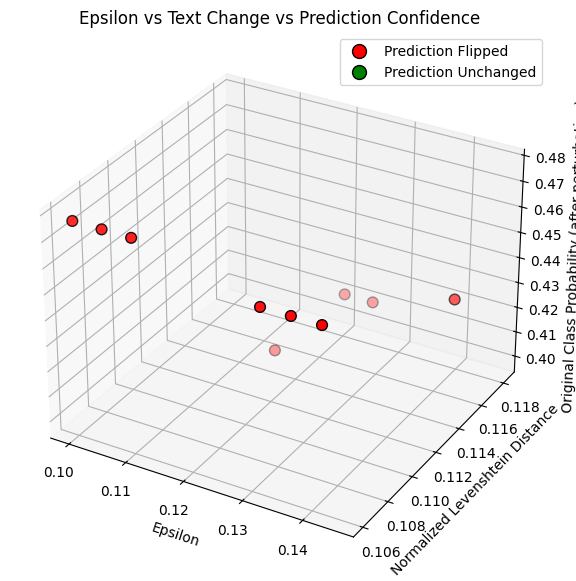

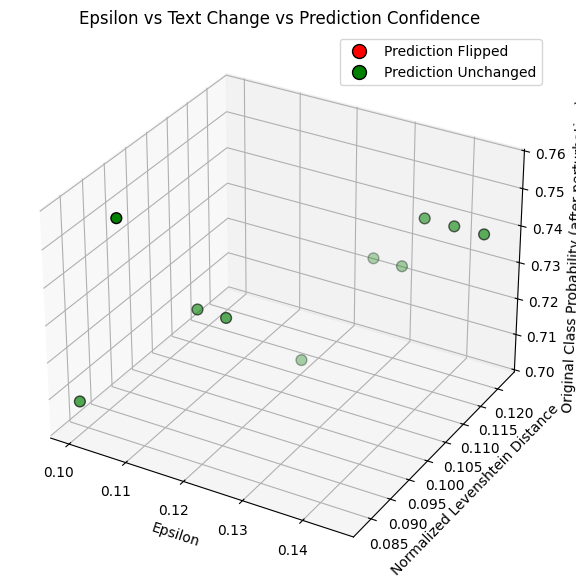

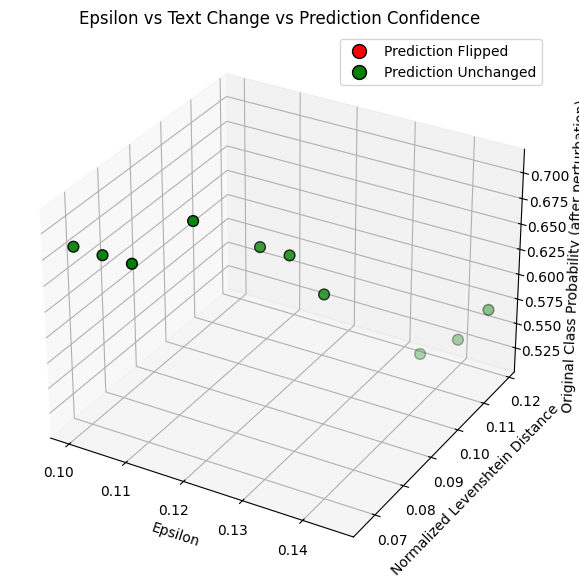

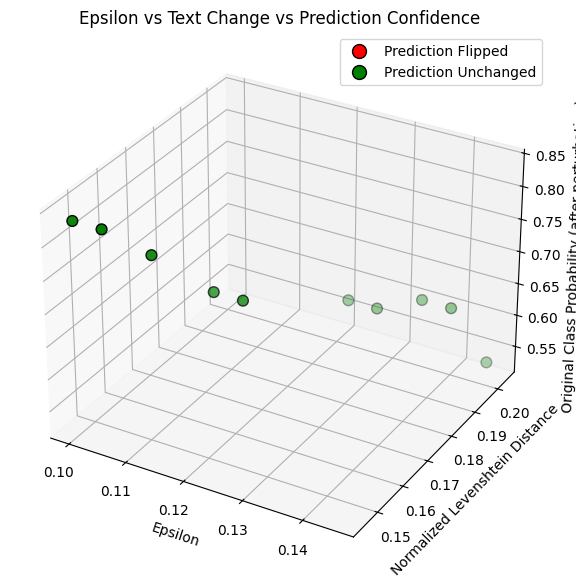

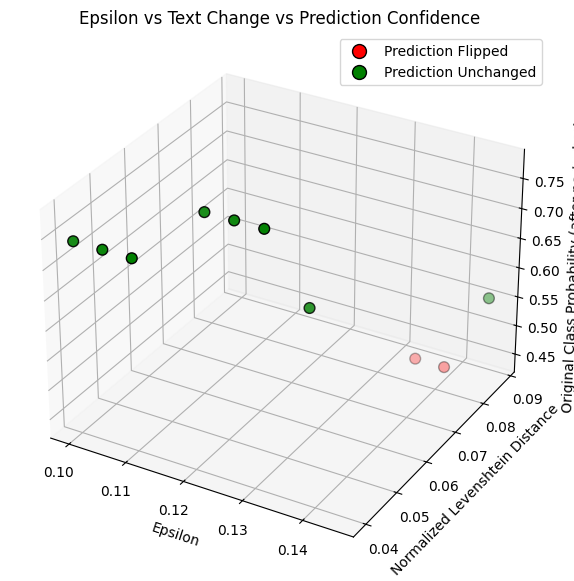

In [ ]:
for i in l2:
  plot1(i)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import Levenshtein
from matplotlib.lines import Line2D

def plot1(*runs):
    plt.figure(figsize=(10, 6))

    for run in runs:
        epsilons = []
        prob_diffs = []
        flipped_flags = []

        for clean, adv, clean_pred, adv_pred, eps in run:
            # Get predicted class on clean input
            orig_class = int(np.argmax(clean_pred))

            # Get probabilities for that class
            # Access the probability correctly from the array
            clean_prob = float(clean_pred[0][orig_class])
            adv_prob = float(adv_pred[0][orig_class])


            # Difference in probability
            prob_diff = clean_prob - adv_prob

            # Check if prediction flipped
            flipped = np.argmax(clean_pred) != np.argmax(adv_pred)

            # Append data
            epsilons.append(eps)
            prob_diffs.append(prob_diff)
            flipped_flags.append(flipped)

        # Choose color for each point based on flip
        colors = ['red' if f else 'green' for f in flipped_flags]

        # Plot line and points
        plt.plot(epsilons, prob_diffs, alpha=0.5, linestyle='-', marker='o', markersize=6,
                 markeredgecolor='k', markerfacecolor='none')  # base line (no color on markers)

        # Overlay color-coded markers
        for x, y, c in zip(epsilons, prob_diffs, colors):
            plt.scatter(x, y, color=c, edgecolors='k', zorder=5)

    # Labels and title
    plt.xlabel("Epsilon")
    plt.ylabel("Clean - Adversarial Probability (Original Class)")
    plt.title("Epsilon vs Confidence Drop (Colored by Flip Status)")

    # Legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Prediction Flipped', markerfacecolor='red', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Prediction Unchanged', markerfacecolor='green', markersize=10, markeredgecolor='black')
    ]
    plt.legend(handles=legend_elements)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot1_levenshtein(*runs):
    import numpy as np
    import matplotlib.pyplot as plt
    import Levenshtein
    from matplotlib.lines import Line2D

    plt.figure(figsize=(10, 6))

    for run in runs:
        epsilons = []
        lev_dists = []
        flipped_flags = []

        for clean, adv, clean_pred, adv_pred, eps in run:
            # Normalized Levenshtein distance
            lev_dist = Levenshtein.distance(clean, adv) / max(len(clean), len(adv))

            # Prediction flip
            flipped = np.argmax(clean_pred) != np.argmax(adv_pred)

            # Append
            epsilons.append(eps)
            lev_dists.append(lev_dist)
            flipped_flags.append(flipped)

        # Line connecting points
        plt.plot(epsilons, lev_dists, linestyle='-', color='gray', alpha=0.5)

        # Colored markers
        for x, y, f in zip(epsilons, lev_dists, flipped_flags):
            color = 'red' if f else 'green'
            plt.scatter(x, y, color=color, edgecolors='k', s=60, zorder=5)

    # Labels and legend
    plt.xlabel("Epsilon")
    plt.ylabel("Normalized Levenshtein Distance")
    plt.title("Epsilon vs Text Perturbation (Red = Prediction Flip)")

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Prediction Flipped',
               markerfacecolor='red', markeredgecolor='black', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Prediction Unchanged',
               markerfacecolor='green', markeredgecolor='black', markersize=10)
    ]
    plt.legend(handles=legend_elements)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


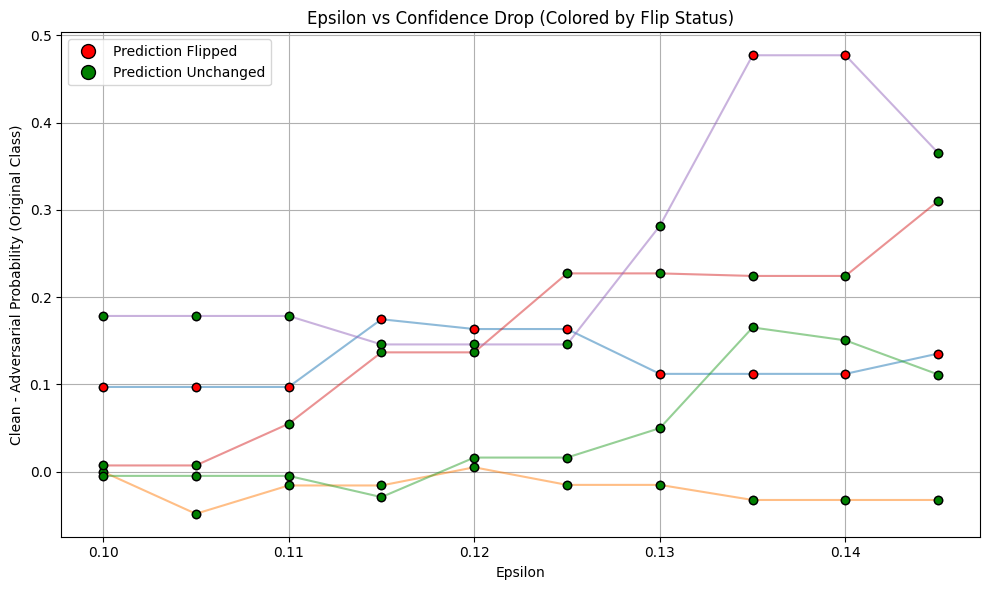

In [ ]:
plot1(l2[0],l2[1], l2[2], l2[3], l2[4])

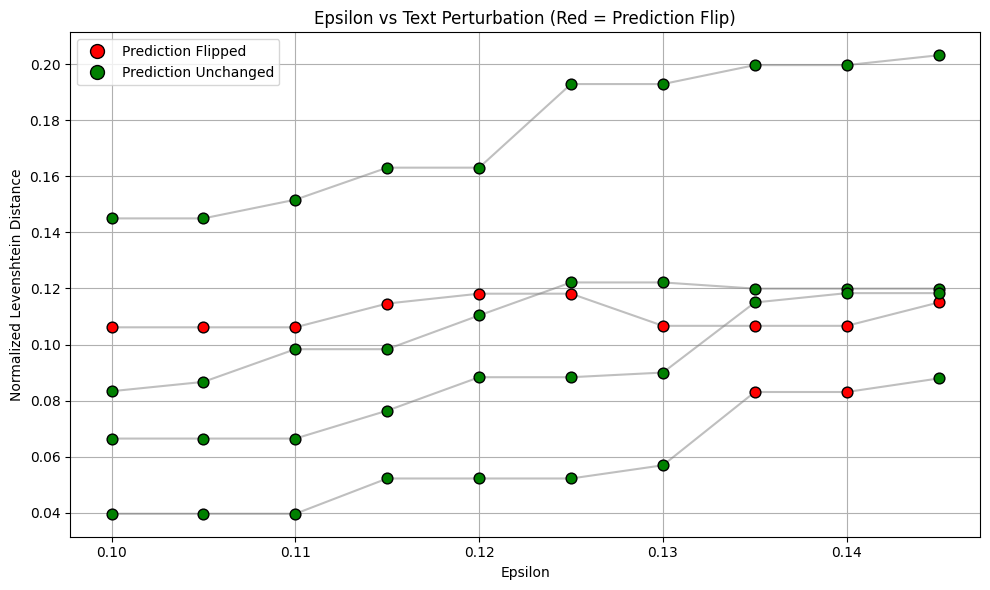

In [ ]:
plot1_levenshtein(l2[0],l2[1], l2[2], l2[3], l2[4])

In [ ]:
print(l2)

[[[' M. KHANWILKAR, J. The principal question involved in these appeals is whether the subject sales  of goods imported from foreign companyntry and after Signature Not Verified Digitally signed by unloading the same on the landmass of the State of West Bengal, DEEPAK SINGH Date 2020.01.21 174050 IST Reason kept in the bonded warehouse without payment of customs duty  to foreign bound ships as ship stores can be regarded as sale within the territory of the State and amenable to sales tax under the West Bengal Sales Tax Act, 1954  for short, the 1954 Act  or the West Bengal Sales Tax Act, 1994  for', 'm. khanwilkar newline j. the principal question involved in these appeals is whether the subject sales of goods imported from foreign companyntry and after signature not verified digitally signed by unloading the same on the landmass of the state of west bengal, deepak singh date 2020. 01. 21 174050 ist reason kept in the bonded warehouse without payment of customs duty to foreign bound sh

In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

def plot_flip_rate_aggregated(*lists):
    epsilon_counts = defaultdict(int)
    epsilon_flips = defaultdict(int)

    # Go through all lists and aggregate
    for run in lists:
        for clean, adv, clean_pred, adv_pred, eps in run:
            flipped = np.argmax(clean_pred) != np.argmax(adv_pred)
            epsilon_counts[eps] += 1
            if flipped:
                epsilon_flips[eps] += 1

    # Compute flip rate per epsilon
    epsilons = sorted(epsilon_counts)
    flip_rates = [(epsilon_flips[eps] / epsilon_counts[eps]) * 100 for eps in epsilons]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epsilons, flip_rates, marker='o', linestyle='-', color='purple')
    plt.xlabel("Epsilon")
    plt.ylabel("Flip Rate (%)")
    plt.title("Overall Prediction Flip Rate vs. Epsilon")
    plt.grid(True)
    plt.ylim(0, 100)
    plt.xticks(epsilons)
    plt.show()


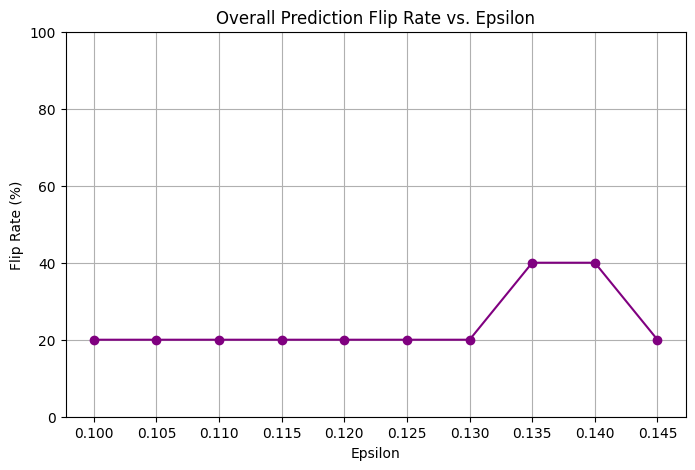

In [ ]:
plot_flip_rate_aggregated(l2[0],l2[1], l2[2], l2[3], l2[4])